In [1]:
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import torch

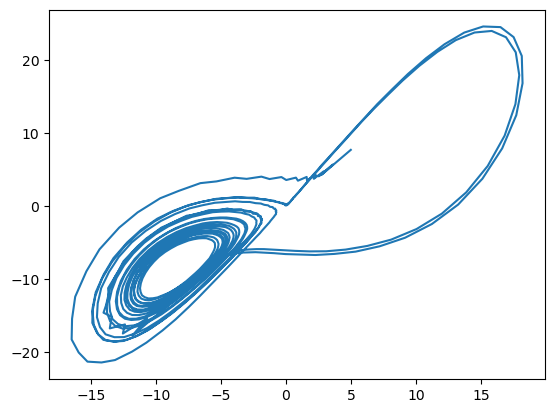

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True,noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [5]:
#try official implementation of s4?
import sys
sys.path.append("/om2/user/ostrow/NN_delay_embeddings/s4")
from models.s4.s4 import S4Block as S4  # Can use full version instead of minimal S4D standalone below
from models.s4.s4d import S4D


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [6]:
class OfficialS4Minimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False,diagonal=True):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        s4 = S4 if not diagonal else S4D

        self.s4 = s4(d_model,d_state=d_state,dropout=dropout)

        self.decoder = nn.Linear(d_model,d_output)
        self.norm = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model,4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model,d_model)
        )

    def forward(self,x):
        # x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        z = x
        if self.prenorm:
            # Prenorm
            z = self.norm(z.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        z, _ = self.s4(z)

        self.hiddens = z.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)

        # Residual connection
        x = z #+ x

        if not self.prenorm:
            # Postnorm
            x = self.norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x, None




In [7]:
model = OfficialS4Minimal(1,1,100,1000)

torch.Size([1, 1000, 1])
torch.Size([1, 1000, 1]) (1000, 100)


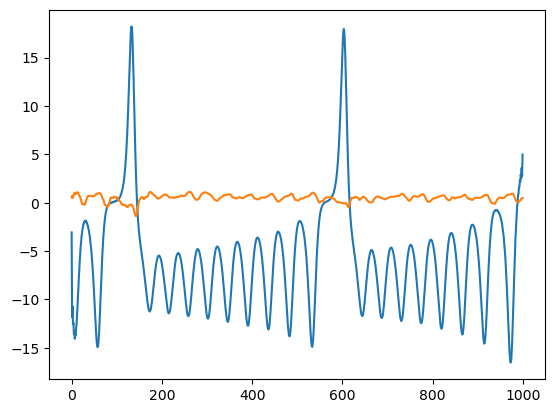

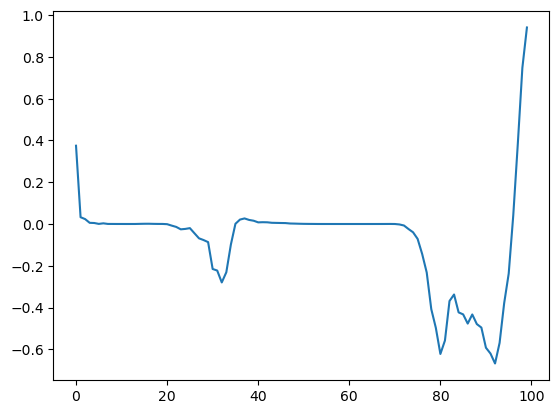

In [8]:
data = torch.tensor(sol[np.newaxis,:,:1]).float()
print(data.size())
plt.figure()
plt.plot(data[0,:,0])


out,_ = model(data)
hidden = model.hiddens.detach().numpy().squeeze()
print(out.shape, hidden.shape)
plt.plot(out.detach().numpy()[0,:,0])

plt.figure()
plt.plot(hidden[:100,0])

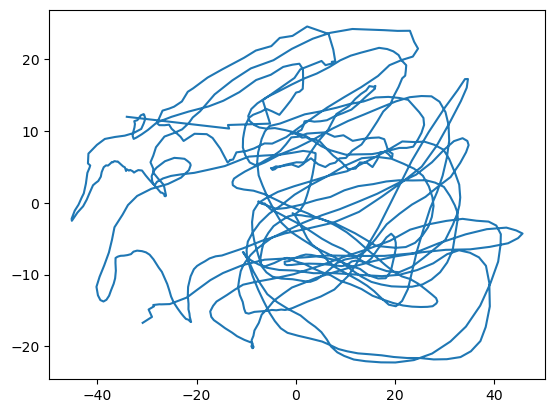

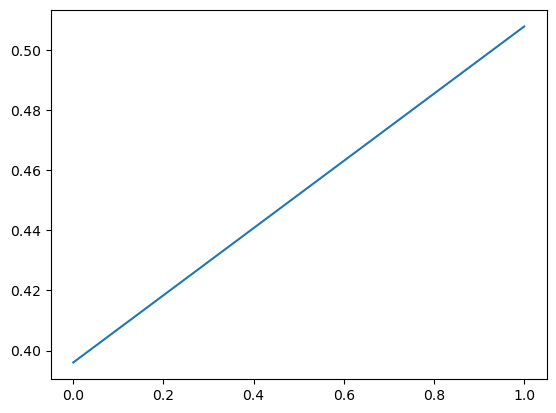

In [9]:
#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [10]:
from utils import make_dataset,train
from torch.optim import AdamW

model = OfficialS4Minimal(1,1,100,1000,dropout=0.1,prenorm=False,diagonal=True)

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,2000,100)

#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cuda')
plt.plot(train_loss)
plt.plot(val_loss)

(100, 2000, 3) torch.Size([100, 2000, 1])


torch.Size([1, 1000, 1])


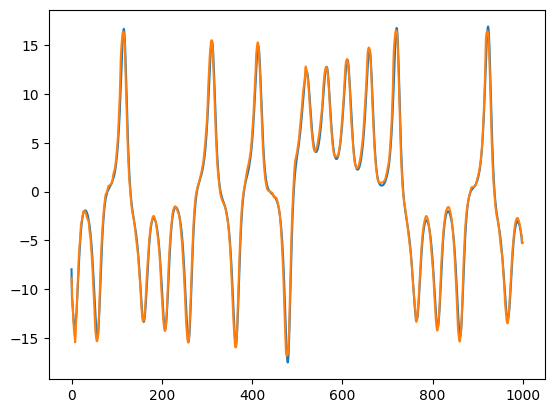

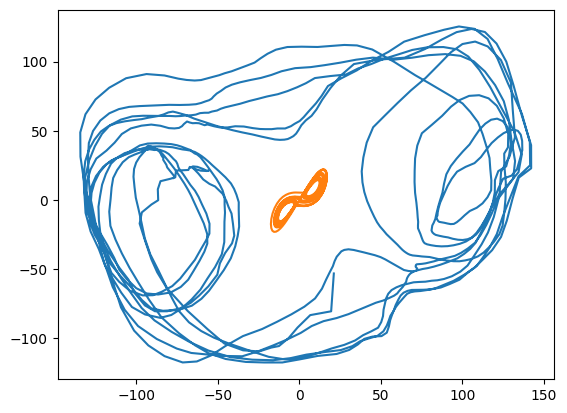

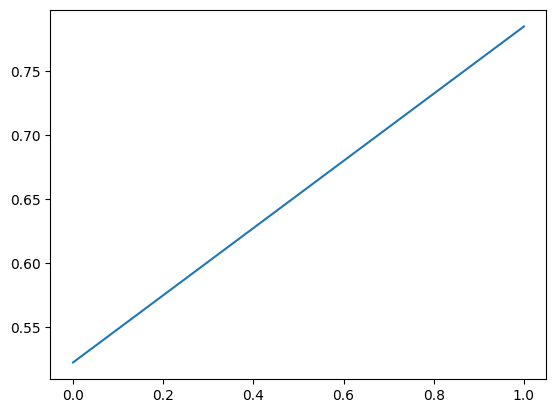

In [ ]:
data = torch.tensor(sol[np.newaxis,:,:1]).float().cuda()
print(data.size())
plt.figure()
plt.plot(data[0,:,0].cpu())


out,_ = model(data)
hidden = model.hiddens.detach().cpu().numpy().squeeze()
out.shape, hidden.shape
plt.plot(out.detach().cpu().numpy()[0,:,0])

#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1],label="reconstructed w PCA")
plt.plot(sol[:,0],sol[:,1],label="original")
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
def hippo_initializer(dim):
    pass

def discretize_dplr(lambd,P,Q,B,C,step,l_max):
    pass

def scan_ssm(ssm,u,x0):
    pass

class minimalS4(nn.Module):
    def __init__(self, input_dim,d_model,n_head):
        super().__init__()

        


In [96]:
import math
from einops import rearrange, repeat

class S4D_rnn(nn.Module):
    #produces the A,B,C,D matrices that recapitulate the s4d kernel below
    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        pass


class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""

    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """

        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

In [108]:
k = S4DKernel(2)
L = 4
self = k

dt = torch.exp(self.log_dt) # (H)
C = torch.view_as_complex(self.C) # (H N)
A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

# Vandermonde multiplication
dtA = A * dt.unsqueeze(-1)  # (H N)
K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
C = C * (torch.exp(dtA)-1.) / A
K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real
K

tensor([[ 0.0005,  0.0215,  0.0420,  0.0594],
        [-0.0892, -0.0363,  0.0305,  0.0749]], grad_fn=<MulBackward0>)